# **Data Overview and Splitting**

In [ ]:
# Import necessary libraries
import pandas as pd  # Data manipulation library
from sklearn.model_selection import train_test_split  # For splitting dataset

# Load dataset from CSV file
file_path = "/content/train.csv"  # Update path if necessary
df = pd.read_csv(file_path)  # Read dataset into a Pandas DataFrame

# Check if dataset contains the required columns
required_columns = {"premise", "hypothesis", "label"}  # Expected columns in dataset
if not required_columns.issubset(df.columns):
    raise ValueError(f"Dataset must contain columns: {required_columns}")

# Split dataset into 80% training and 20% testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Print dataset information
print(f"Total Samples: {len(df)}")  # Print total number of samples in dataset
print(f"Training Samples: {len(train_df)}")  # Print training set size
print(f"Testing Samples: {len(test_df)}")  # Print test set size

# Display first few rows of training set
print("\nTraining Set Sample:")
print(train_df.head())  # Show first few rows of training data

# Display first few rows of testing set
print("\nTest Set Sample:")
print(test_df.head())  # Show first few rows of test data


Total Samples: 12120
Training Samples: 9696
Testing Samples: 2424

Training Set Sample:
              id                                            premise  \
5289  4e5ad9e03a                               اب اتنا خفیہ تھا یہ.   
6647  fea0d3c7e8                           oh  that's accommodating   
1245  4ce586b61e  more than anything else in this day and age th...   
4417  0dbcd1012b  Aie! les boucaniers en-dessous s'écriaient, et...   
5662  157895e59c             一个采购战略组织，是壮大的力资本发展战略的一部分, 这是在原则VI上讨论的。   

                                             hypothesis lang_abv language  \
5289                              یہ عوامی معلومات تھی۔       ur     Urdu   
6647                                That is disruptive.       en  English   
1245  In your decisions age is a big factor, and I a...       en  English   
4417  Les Buccaneers étaient bruyants quand ils disa...       fr   French   
5662                              原则四涉及财富500强机构的资本发展战略。       zh  Chinese   

      label  
5289    

# **Tokenizer and Padding**

In [ ]:
# Import necessary libraries
import torch  # PyTorch for tensor operations
from torch.utils.data import Dataset  # PyTorch Dataset class

# Define a PyTorch Dataset class for sentence classification
class SentenceDataset(Dataset):
    """
    A custom PyTorch Dataset class for handling text classification data.

    This class:
    - Tokenizes input text (premise and hypothesis) using a pre-trained tokenizer.
    - Returns tokenized inputs along with attention masks and labels as tensors.

    Parameters:
        df (pd.DataFrame): The dataset containing 'premise', 'hypothesis', and 'label'.
        tokenizer (PreTrainedTokenizer): The pre-trained tokenizer for encoding text.
        max_length (int): Maximum sequence length for tokenization.

    Returns:
        dict: A dictionary containing:
            - 'input_ids': Tokenized sentence representations.
            - 'attention_mask': Attention mask indicating valid tokens.
            - 'label': The class label as a tensor.
    """
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df.reset_index(drop=True)  # Reset index to avoid issues
        self.tokenizer = tokenizer  # Assign tokenizer
        self.max_length = max_length  # Set max token length

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.df)

    def __getitem__(self, index):
        """
        Retrieves and processes a single sample from the dataset at the given index.

        Parameters:
            index (int): The row index in the dataset.

        Returns:
            dict: A dictionary containing:
                - 'input_ids': Encoded token IDs (Tensor)
                - 'attention_mask': Mask indicating valid vs. padding tokens (Tensor)
                - 'label': Corresponding class label (Tensor)
        """
        row = self.df.iloc[index]  # Fetch the row at the given index

        # Tokenize the input text (premise and hypothesis)
        inputs = self.tokenizer(
            row["premise"],  # First input sentence (Premise)
            row["hypothesis"],  # Second input sentence (Hypothesis)
            padding="max_length",  # Ensures all sequences have equal length
            truncation=True,  # Truncate if sequence exceeds max_length
            max_length=self.max_length,  # Set maximum length for tokenization
            return_tensors="pt"  # Return as PyTorch tensors
        )

        # Extract tokenized outputs and remove batch dimension (squeeze)
        input_ids = inputs["input_ids"].squeeze(0)  # Convert [1, max_length] → [max_length]
        attention_mask = inputs["attention_mask"].squeeze(0)  # Convert [1, max_length] → [max_length]
        label = torch.tensor(row["label"], dtype=torch.long)  # Convert label to tensor (long type for classification)

        # Return the processed sample
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": label
        }

# Print confirmation message
print("SentenceDataset class has been successfully modified!")


SentenceDataset class has been successfully modified!


In [ ]:
# Ignore general warnings to keep output clean
import warnings
warnings.filterwarnings("ignore")

# Suppress tokenizer warnings from Hugging Face transformers library
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

# Import necessary libraries
from torch.utils.data import DataLoader
from transformers import XLMRobertaTokenizer  # Ensure tokenizer is available

# Load XLM-RoBERTa tokenizer (suppressing Hugging Face warnings)
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

# Create PyTorch Dataset instances for training and testing
train_dataset = SentenceDataset(train_df, tokenizer)
test_dataset = SentenceDataset(test_df, tokenizer)

# Create DataLoaders for batch processing
train_loader = DataLoader(
    train_dataset,  # Training dataset
    batch_size=16,  # Define batch size (16 samples per batch)
    shuffle=True,  # Shuffle the training data for randomness
    num_workers=2  # Use multiple workers for faster data loading (set to 0 if using CPU)
)

test_loader = DataLoader(
    test_dataset,  # Testing dataset
    batch_size=16,  # Define batch size (same as training)
    shuffle=False,  # No shuffling for test set (ensures consistency)
    num_workers=2  # Use multiple workers for efficiency
)

# Print confirmation and check batch loading
print("DataLoaders for training and testing created successfully!")

# Check the shape of one batch from the train_loader
for batch in train_loader:
    print("First batch loaded successfully!")
    print({key: val.shape for key, val in batch.items()})  # Print tensor shapes
    break


DataLoaders for training and testing created successfully!
First batch loaded successfully!
{'input_ids': torch.Size([16, 128]), 'attention_mask': torch.Size([16, 128]), 'label': torch.Size([16])}


# **Model Training**

In [ ]:
# Ignore general warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Import necessary libraries
import torch
from tqdm import tqdm  # For displaying training progress

# Define the training function
def train_model(model, train_loader, test_loader, optimizer, loss_fn, device, epochs=5):
    """
    Train and evaluate the model.

    Parameters:
        model (torch.nn.Module): The XLM-RoBERTa classification model.
        train_loader (DataLoader): DataLoader for the training set.
        test_loader (DataLoader): DataLoader for the test set.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        loss_fn (torch.nn.Module): Loss function for classification.
        device (torch.device): Device to run the training on (CPU/GPU).
        epochs (int): Number of training epochs.

    Prints:
        - Training loss after each epoch
        - Validation loss after each epoch
    """

    model.train()  # Set model to training mode

    for epoch in range(epochs):  # Iterate over epochs
        total_train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")  # Progress bar

        for batch in loop:
            optimizer.zero_grad()  # Clear previous gradients

            # Move batch data to GPU/CPU
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)

            # Backward pass and weight update
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()  # Track training loss
            loop.set_postfix(loss=loss.item())  # Update progress bar with loss

        avg_train_loss = total_train_loss / len(train_loader)  # Compute average training loss
        print(f"\nEpoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

        # Evaluate on the test set
        evaluate_model(model, test_loader, device)

    print("Training completed successfully!")

# Define the evaluation function
def evaluate_model(model, data_loader, device):
    """
    Evaluates the model on the test set and prints the validation loss.

    Parameters:
        model (torch.nn.Module): Trained model to evaluate.
        data_loader (DataLoader): DataLoader for evaluation (test set).
        device (torch.device): Device to run the evaluation on (CPU/GPU).
    """
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    loss_fn = torch.nn.CrossEntropyLoss()  # Define loss function for validation
    predictions, true_labels = [], []

    with torch.no_grad():  # Disable gradient calculation
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            total_val_loss += loss.item()

            # Convert logits to predicted class
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(labels)

    avg_val_loss = total_val_loss / len(data_loader)  # Compute average validation loss
    print(f"Validation Loss: {avg_val_loss:.4f}")

# Load Pretrained XLM-R Model (3-class classification)
from transformers import XLMRobertaForSequenceClassification, AdamW

model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3)

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

# Define Loss Function
loss_fn = torch.nn.CrossEntropyLoss()

# Print model info
print(f"Model successfully loaded on {device}!")

# Train model for 3 epochs
train_model(model, train_loader, test_loader, optimizer, loss_fn, device, epochs=5)


Model successfully loaded on cuda!


Epoch 1/5: 100%|██████████| 606/606 [03:58<00:00,  2.54it/s, loss=0.914]


Epoch 1 Training Loss: 1.0660


Validation Loss: 0.9641


Epoch 2/5: 100%|██████████| 606/606 [03:50<00:00,  2.63it/s, loss=0.537]


Epoch 2 Training Loss: 0.7453


Validation Loss: 0.7152


Epoch 3/5: 100%|██████████| 606/606 [03:50<00:00,  2.63it/s, loss=0.136]


Epoch 3 Training Loss: 0.4361


Validation Loss: 0.7624


Epoch 4/5: 100%|██████████| 606/606 [03:50<00:00,  2.63it/s, loss=0.217]


Epoch 4 Training Loss: 0.1912


Validation Loss: 0.9028


Epoch 5/5: 100%|██████████| 606/606 [03:50<00:00,  2.63it/s, loss=0.0196]


Epoch 5 Training Loss: 0.0791


Validation Loss: 1.2044
Training completed successfully!


# **Model Evaluation**

In [ ]:
# Import necessary library for evaluation metrics
from sklearn.metrics import classification_report

# Define a function to evaluate the trained model on test data
def test_model_performance(model, data_loader, device):
    """
    Evaluates the trained model and prints Precision, Recall, and F1-score.

    Parameters:
        model (torch.nn.Module): Trained classification model.
        data_loader (DataLoader): DataLoader for test set.
        device (torch.device): CPU or GPU device.

    Prints:
        - Classification report (Precision, Recall, F1-score)
    """

    model.eval()  # Set model to evaluation mode
    predictions, true_labels = [], []

    with torch.no_grad():  # Disable gradient calculations
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Extract logits

            # Convert logits to predicted class labels
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(labels)

    # Print classification report
    print("\nModel Performance on Test Set:")
    print(classification_report(true_labels, predictions, digits=4))

# Run the evaluation on test data
test_model_performance(model, test_loader, device)



Model Performance on Test Set:
              precision    recall  f1-score   support

           0     0.7035    0.7109    0.7072       851
           1     0.6407    0.6481    0.6444       773
           2     0.7289    0.7125    0.7206       800

    accuracy                         0.6914      2424
   macro avg     0.6910    0.6905    0.6907      2424
weighted avg     0.6918    0.6914    0.6916      2424



In [ ]:
# Import required libraries
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Recompute true labels and predictions
def get_predictions(model, data_loader, device):
    """
    Extracts model predictions and true labels from the test set.

    Returns:
        true_labels (list): List of actual labels.
        predictions (list): List of predicted labels.
        logits (numpy array): Raw model output scores before softmax.
    """
    model.eval()  # Set model to evaluation mode
    true_labels, predictions, logits = [], [], []

    with torch.no_grad():  # Disable gradient calculations
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logit_values = outputs.logits.cpu().numpy()  # Convert logits to numpy
            preds = np.argmax(logit_values, axis=1)  # Get predicted class

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds)
            logits.extend(logit_values)

    return np.array(true_labels), np.array(predictions), np.array(logits)

# Compute values
true_labels, predictions, logits = get_predictions(model, test_loader, device)

print("Predictions and true labels extracted successfully!")


Predictions and true labels extracted successfully!


# **Confuse Matrix and AUC-ROC Curve**

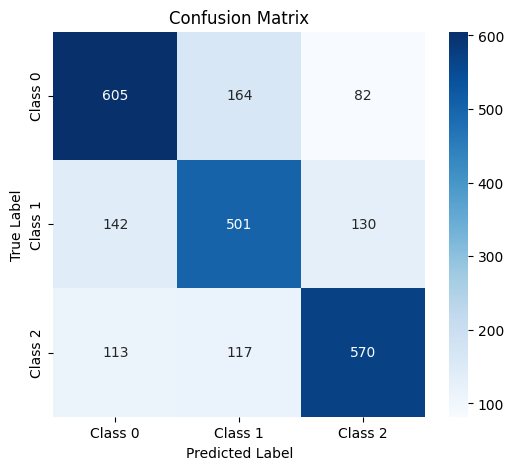

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names):
    """
    Plots a Confusion Matrix to analyze misclassifications.
    """
    cm = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Define class names (modify if necessary)
class_names = ["Class 0", "Class 1", "Class 2"]

# Call function to plot confusion matrix
plot_confusion_matrix(true_labels, predictions, class_names)


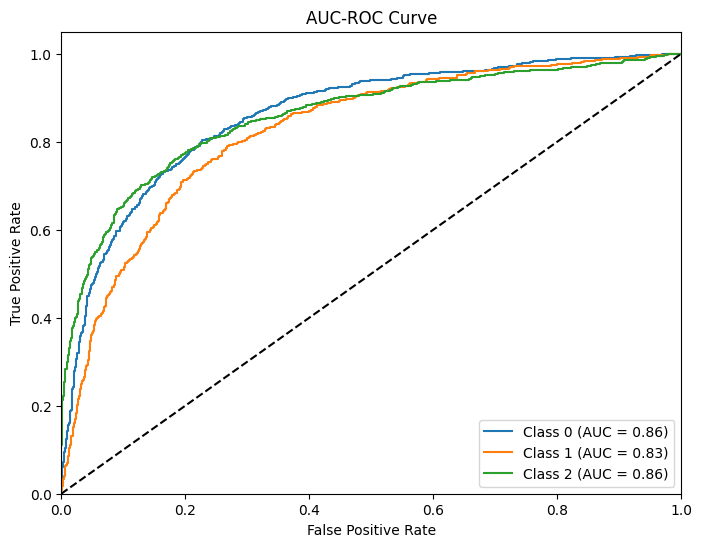

In [ ]:
# Function to plot AUC-ROC Curve
def plot_auc_roc_curve(true_labels, logits, num_classes):
    """
    Plots the AUC-ROC curve for multi-class classification.

    Parameters:
        true_labels (list): True class labels.
        logits (numpy array): Raw model output scores before softmax.
        num_classes (int): Number of classes in classification.
    """
    plt.figure(figsize=(8, 6))

    # Convert true labels to one-hot encoding
    true_labels_one_hot = np.eye(num_classes)[true_labels]

    # Compute ROC curve and AUC for each class
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], logits[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], "k--")  # Random chance line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC-ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# Call function to plot AUC-ROC
plot_auc_roc_curve(true_labels, logits, num_classes=3)
